In [3]:

# 1. Imports
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import shap

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from xgboost import XGBRegressor

c:\Users\sacii\OneDrive\Desktop\Oslomet\ACIT4510 Statistical learning\ACIT4510_statistical_learning_project\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [17]:
# ============================================
# 0. Setup figure directory
# ============================================
import os

fig_dir = r"C:\Users\sacii\OneDrive\Desktop\Oslomet\ACIT4510 Statistical learning\ACIT4510_statistical_learning_project\figures\shap"
os.makedirs(fig_dir, exist_ok=True)

In [4]:

# 2. Load raw train + test
data_path_raw = r"C:\Users\sacii\OneDrive\Desktop\Oslomet\ACIT4510 Statistical learning\ACIT4510_statistical_learning_project\data\raw"

train_df = pd.read_csv(fr"{data_path_raw}\train_df.csv")
test_df  = pd.read_csv(fr"{data_path_raw}\test_df.csv")

print("Train:", train_df.shape, "| Test:", test_df.shape)

target_col = "Happiness Score"

X_train = train_df.drop(columns=target_col).copy()
y_train = train_df[target_col].copy()

X_test = test_df.drop(columns=target_col).copy()
y_test = test_df[target_col].copy()


Train: (1920, 12) | Test: (600, 12)


In [6]:
# 3. Feature engineering for XGBoost: Sleep_exercise + Healthy_index
exercise_map = {"Low": 0.0, "Moderate": 0.5, "High": 1.0}
diet_map = {
    "Junk Food": 0.0,
    "Keto": 0.5,
    "Vegetarian": 0.7,
    "Vegan": 0.9,
    "Balanced": 1.0,
}
stress_map = {"High": 0.0, "Moderate": 0.5, "Low": 1.0}

def add_engineered_features(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df["Exercise_Num"] = df["Exercise Level"].map(exercise_map)
    df["Diet_Num"] = df["Diet Type"].map(diet_map)
    df["Stress_Num"] = df["Stress Level"].map(stress_map)

    df["Sleep_exercise"] = df["Sleep Hours"] * df["Exercise_Num"]
    df["Healthy_index"] = (df["Exercise_Num"] + df["Diet_Num"] + df["Stress_Num"]) / 3.0
    return df

X_train_fe = add_engineered_features(X_train)
X_test_fe  = add_engineered_features(X_test)

print("Columns after feature engineering:")
print(X_train_fe.columns.tolist())


Columns after feature engineering:
['Country', 'Age', 'Gender', 'Exercise Level', 'Diet Type', 'Sleep Hours', 'Stress Level', 'Mental Health Condition', 'Work Hours per Week', 'Screen Time per Day (Hours)', 'Social Interaction Score', 'Exercise_Num', 'Diet_Num', 'Stress_Num', 'Sleep_exercise', 'Healthy_index']


In [8]:
# 4. One-hot encode categoricals (no scaling) for XGBoost
numeric_features_xgb = [
    "Sleep Hours",
    "Screen Time per Day (Hours)",
    "Work Hours per Week",
    "Social Interaction Score",
    "Sleep_exercise",
    "Healthy_index",
]

categorical_features_xgb = ["Exercise Level", "Diet Type", "Stress Level"]

ohe_only_transformer = ColumnTransformer(
    transformers=[
        ("num", "passthrough", numeric_features_xgb),
        ("cat", OneHotEncoder(drop="first", sparse_output=False), categorical_features_xgb),
    ],
    remainder="drop",
)

X_train_xgb = ohe_only_transformer.fit_transform(X_train_fe)
X_test_xgb  = ohe_only_transformer.transform(X_test_fe)

X_train_xgb = X_train_xgb.astype("float32")
X_test_xgb  = X_test_xgb.astype("float32")

print("X_train_xgb shape:", X_train_xgb.shape)
print("X_test_xgb  shape:", X_test_xgb.shape)



X_train_xgb shape: (1920, 14)
X_test_xgb  shape: (600, 14)


In [9]:
# 5. Build feature names for SHAP (numeric + expanded one-hot categoricals)
feature_names_xgb = list(numeric_features_xgb)

ohe = ohe_only_transformer.named_transformers_["cat"]
cat_feature_names = []

for col_name, cats in zip(categorical_features_xgb, ohe.categories_):
    # drop='first' means first category is omitted
    for cat in cats[1:]:
        cat_feature_names.append(f"{col_name}={cat}")

feature_names_xgb.extend(cat_feature_names)

print("Number of feature names:", len(feature_names_xgb))
print("X_train_xgb columns:", X_train_xgb.shape[1])

assert len(feature_names_xgb) == X_train_xgb.shape[1]

X_train_xgb_df = pd.DataFrame(X_train_xgb, columns=feature_names_xgb)
X_test_xgb_df  = pd.DataFrame(X_test_xgb,  columns=feature_names_xgb)



Number of feature names: 14
X_train_xgb columns: 14


In [10]:
# 6. Train final XGBoost model (best params from Optuna)
best_params = {
    "n_estimators": 432,
    "max_depth": 3,
    "learning_rate": 0.011214720931319094,
    "subsample": 0.9091705575686873,
    "colsample_bytree": 0.7710206698824025,
    "min_child_weight": 10,
    "gamma": 4.637013156646108,
    "reg_alpha": 0.0022450836842314863,
    "reg_lambda": 5.305992936571093e-07,
    "random_state": 42,
    "n_jobs": -1,
    "tree_method": "hist",
    "objective": "reg:squarederror",
}

final_xgb = XGBRegressor(**best_params)
final_xgb.fit(X_train_xgb_df, y_train)

y_test_pred = final_xgb.predict(X_test_xgb_df)

mae_test = mean_absolute_error(y_test, y_test_pred)
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
r2_test = r2_score(y_test, y_test_pred)

print("Final XGBoost performance on test set")
print("MAE :", mae_test)
print("RMSE:", rmse_test)
print("R²  :", r2_test)



Final XGBoost performance on test set
MAE : 2.214779945373535
RMSE: 2.5708066621486463
R²  : -0.013890756178241093


In [11]:
# 7. SHAP explainer and SHAP values
shap.initjs()

explainer = shap.TreeExplainer(final_xgb)
shap_values = explainer.shap_values(X_train_xgb_df)


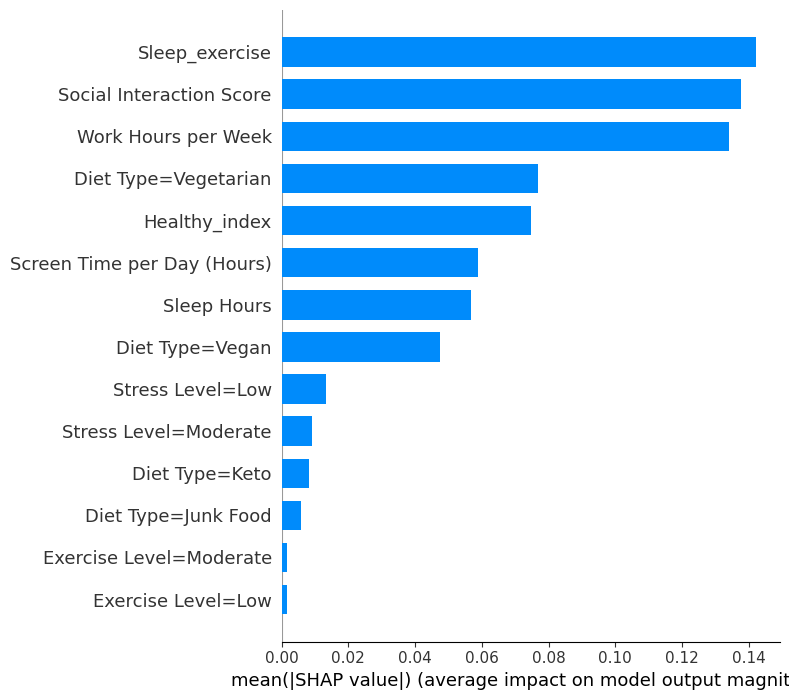

In [18]:
# ============================================
# 8. Global feature importance: SHAP summary bar plot
# ============================================

import os
plt.figure(figsize=(10, 6))

shap.summary_plot(
    shap_values,
    X_train_xgb_df,
    feature_names=feature_names_xgb,
    plot_type="bar",
    max_display=15,
    show=False  # important: prevent automatic display
)

plt.tight_layout()
plt.savefig(os.path.join(fig_dir, "shap_summary_bar.png"), dpi=300)
plt.show()
plt.close()


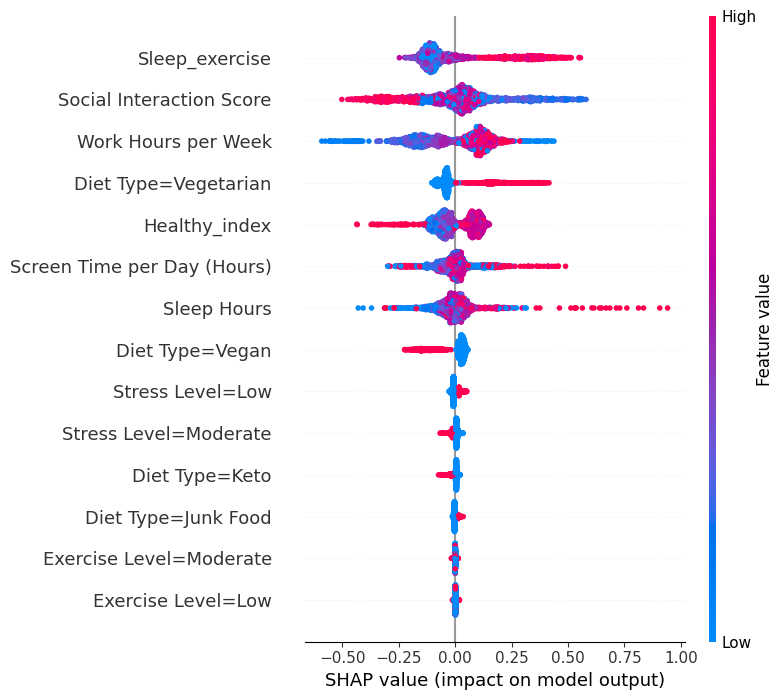

In [19]:
# ============================================
# 9. Global impact distribution: SHAP beeswarm plot
# ============================================
plt.figure(figsize=(10, 6))

shap.summary_plot(
    shap_values,
    X_train_xgb_df,
    feature_names=feature_names_xgb,
    max_display=15,
    show=False
)

plt.tight_layout()
plt.savefig(os.path.join(fig_dir, "shap_beeswarm.png"), dpi=300)
plt.show()
plt.close()


<Figure size 800x500 with 0 Axes>

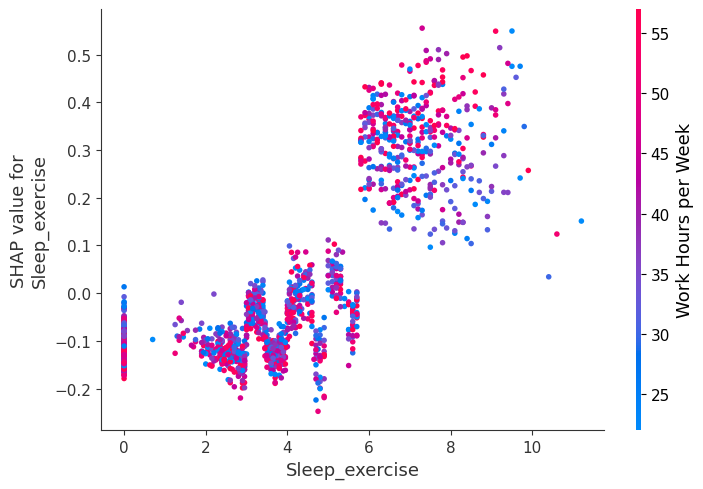

<Figure size 800x500 with 0 Axes>

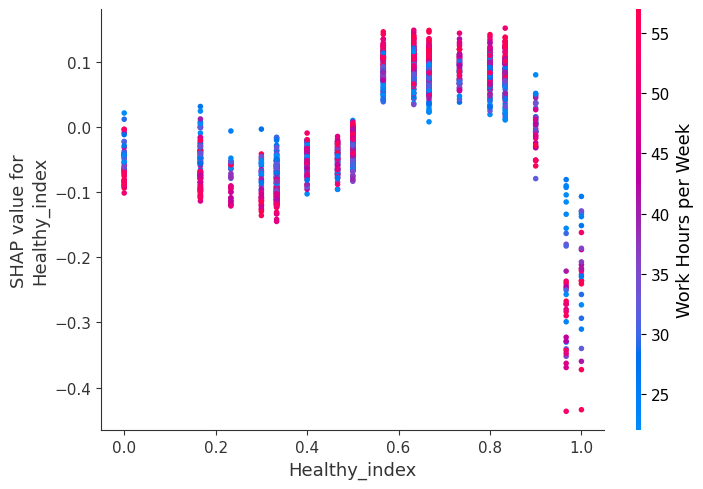

In [20]:
# ============================================
# 10A. SHAP dependence: Sleep_exercise
# ============================================
plt.figure(figsize=(8, 5))

shap.dependence_plot(
    "Sleep_exercise",
    shap_values,
    X_train_xgb_df,
    feature_names=feature_names_xgb,
    show=False
)

plt.tight_layout()
plt.savefig(os.path.join(fig_dir, "shap_dependence_sleep_exercise.png"), dpi=300)
plt.show()
plt.close()


# ============================================
# 10B. SHAP dependence: Healthy_index
# ============================================
plt.figure(figsize=(8, 5))

shap.dependence_plot(
    "Healthy_index",
    shap_values,
    X_train_xgb_df,
    feature_names=feature_names_xgb,
    show=False
)

plt.tight_layout()
plt.savefig(os.path.join(fig_dir, "shap_dependence_healthy_index.png"), dpi=300)
plt.show()
plt.close()
